The data comes from: <br> 
https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/rca_microservice_architecture_latencies.csv <br>

For causal analysis see: <br>
https://www.pywhy.org/dowhy/main/example_notebooks/gcm_rca_microservice_architecture.html <br>

Following graph is the DAG of causal relationships.
![alt](microservice_structurejpg.jpg)

In [2]:
import pandas as pd

microservice_df = pd.read_csv('rca_microservice_architecture_latencies.csv')
microservice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product DB             10000 non-null  float64
 1   Customer DB            10000 non-null  float64
 2   Order DB               10000 non-null  float64
 3   Shipping Cost Service  10000 non-null  float64
 4   Caching Service        10000 non-null  float64
 5   Product Service        10000 non-null  float64
 6   Auth Service           10000 non-null  float64
 7   Order Service          10000 non-null  float64
 8   API                    10000 non-null  float64
 9   www                    10000 non-null  float64
 10  Website                10000 non-null  float64
dtypes: float64(11)
memory usage: 859.5 KB


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


[['Customer DB', 'Auth Service', 'API', 'www', 'Website'], ['Product DB', 'Shipping Cost Service', 'Caching Service', 'Product Service']]


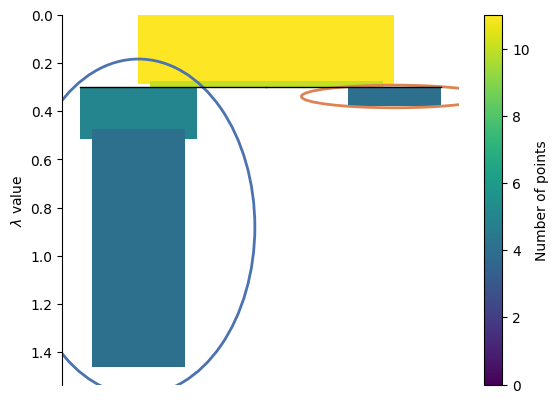

In [4]:
import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(44)

methods = ['pearson', 'spearman', 'kendall']
combined_relation_metric = sum( microservice_df.corr(method=method).abs() for method in methods)/len(methods) 

# Your existing code...
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True,metric='l1', cluster_selection_epsilon=1)
cluster_labels = clusterer.fit_predict(1-combined_relation_metric)


# Create a dictionary where keys are cluster labels and values are lists of column names
clusters_dic = {label: [] for label in set(cluster_labels)}
for column, label in zip(microservice_df.columns, cluster_labels):
    clusters_dic[label].append(column)

clusters = [cluster for cluster in clusters_dic.values() ]

# Get the persistence of each cluster
persistence = clusterer.cluster_persistence_

# Create a list of tuples where each tuple is (cluster_label, persistence)
cluster_persistence = [(label, persistence[i]) for i, label in enumerate(set(cluster_labels)) if label != -1]

# Sort the list of tuples by persistence, in descending order
clusters_sorted_by_persistence = sorted(cluster_persistence, key=lambda x: x[1], reverse=True)

# Reorder the clusters based on the sorted persistence
reordered_clusters = [clusters_dic[label] for label, _ in clusters_sorted_by_persistence]

print(reordered_clusters)

reordered_columns = [column for cluster in reordered_clusters for column in cluster]

reordered_columns += clusters_dic.get(-1, [])
reordered_columns[5], reordered_columns[8] = reordered_columns[8], reordered_columns[5]

# Plot the condensed tree
clusterer.condensed_tree_.plot(select_clusters=True,
          selection_palette=sns.color_palette('deep', 8))
plt.show()

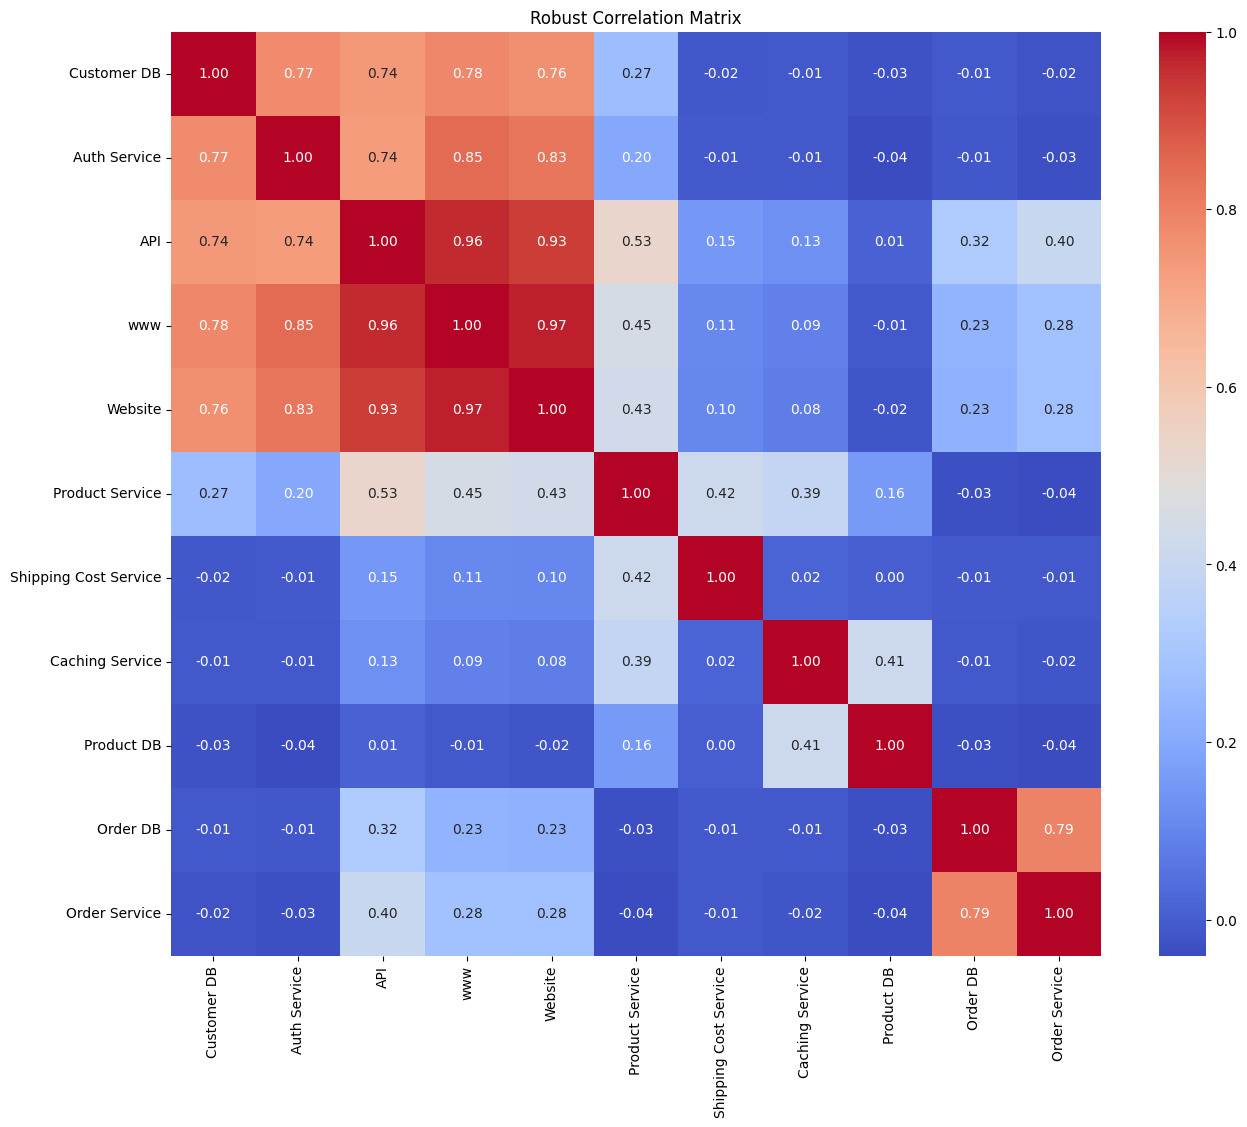

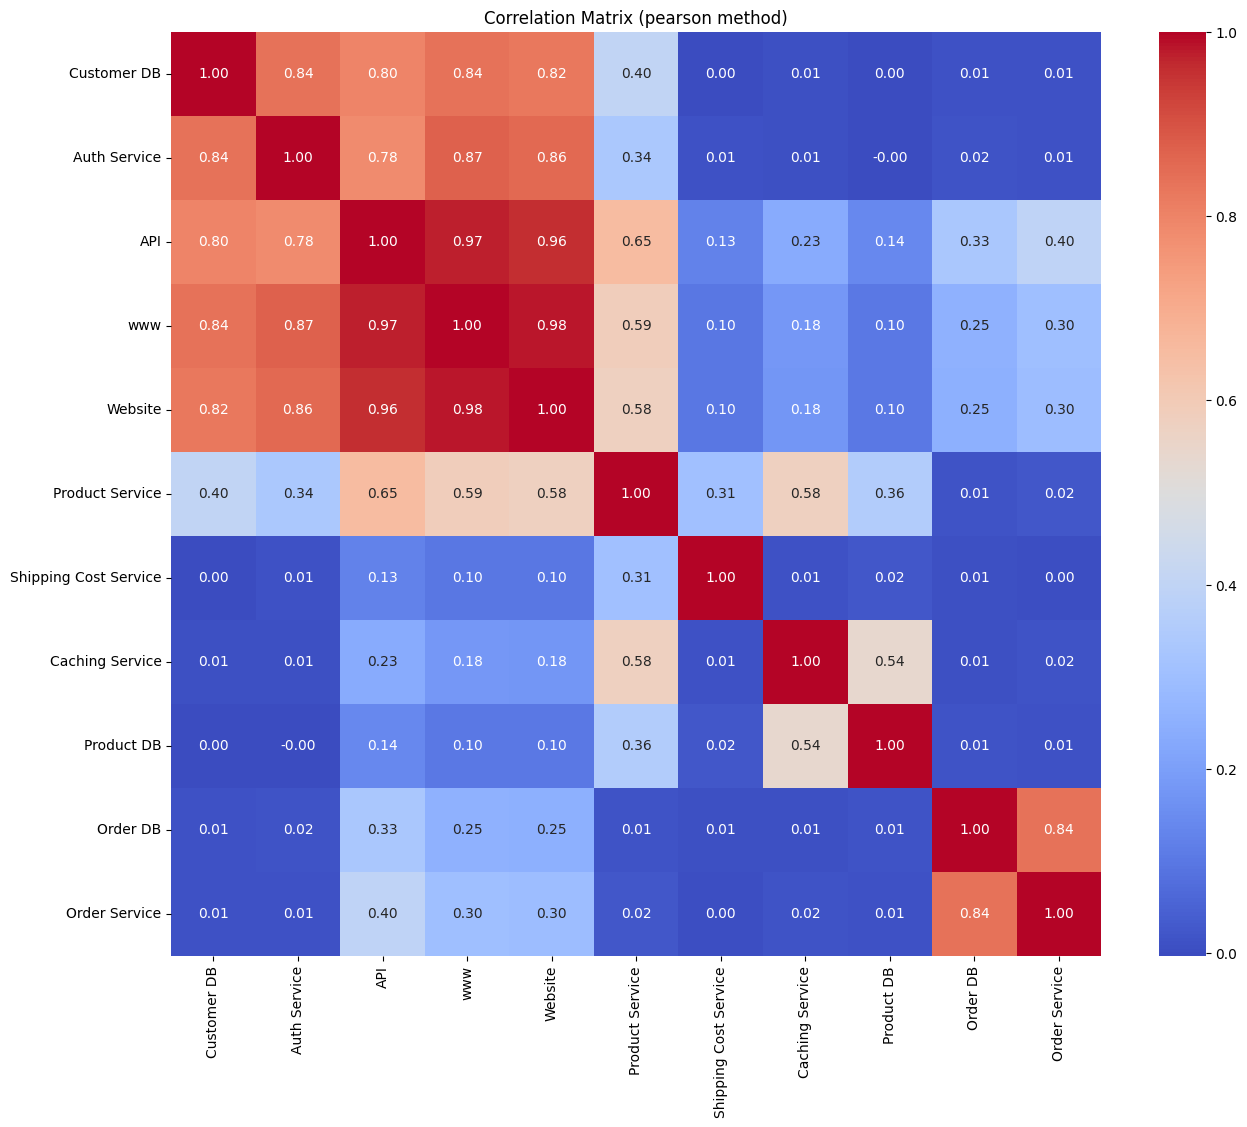

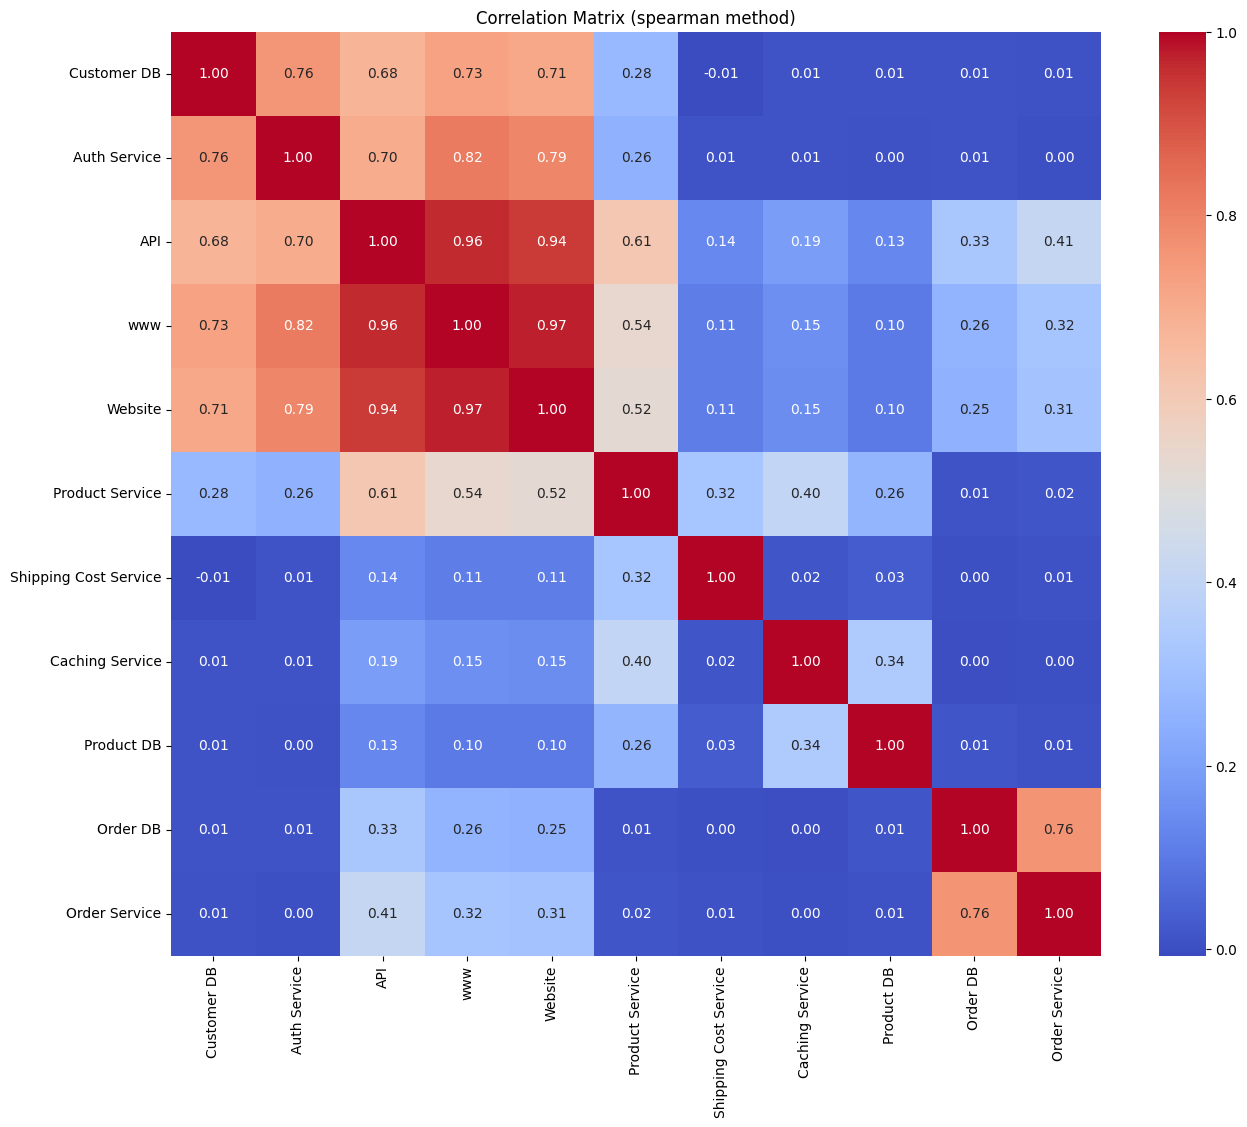

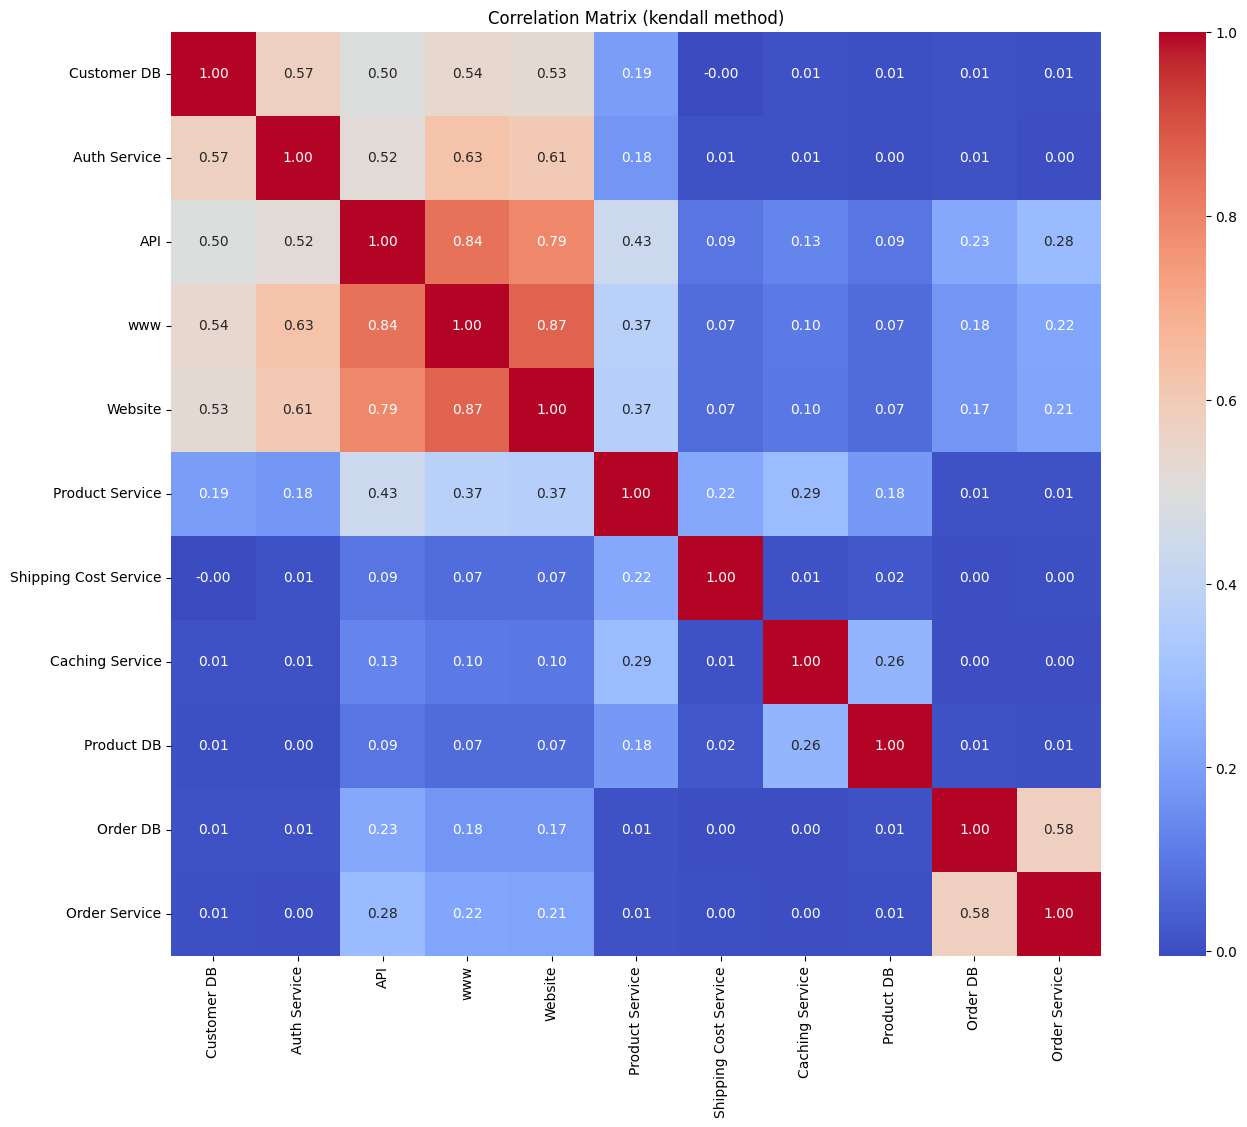

In [5]:
from sklearn.covariance import MinCovDet

np.random.seed(41)
mcd = MinCovDet().fit(microservice_df)

cov_matrix = pd.DataFrame(mcd.covariance_, columns=microservice_df.columns, index=microservice_df.columns)
std_dev = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)

# Plot the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix.loc[reordered_columns,reordered_columns], annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Robust Correlation Matrix')
plt.show()

# Loop over correlation methods
methods = ['pearson', 'spearman', 'kendall']
for method in methods:
    plt.figure(figsize=(15, 12))
    sns.heatmap(microservice_df.corr(method=method).loc[reordered_columns,reordered_columns], annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(f'Correlation Matrix ({method} method)')
    plt.show()

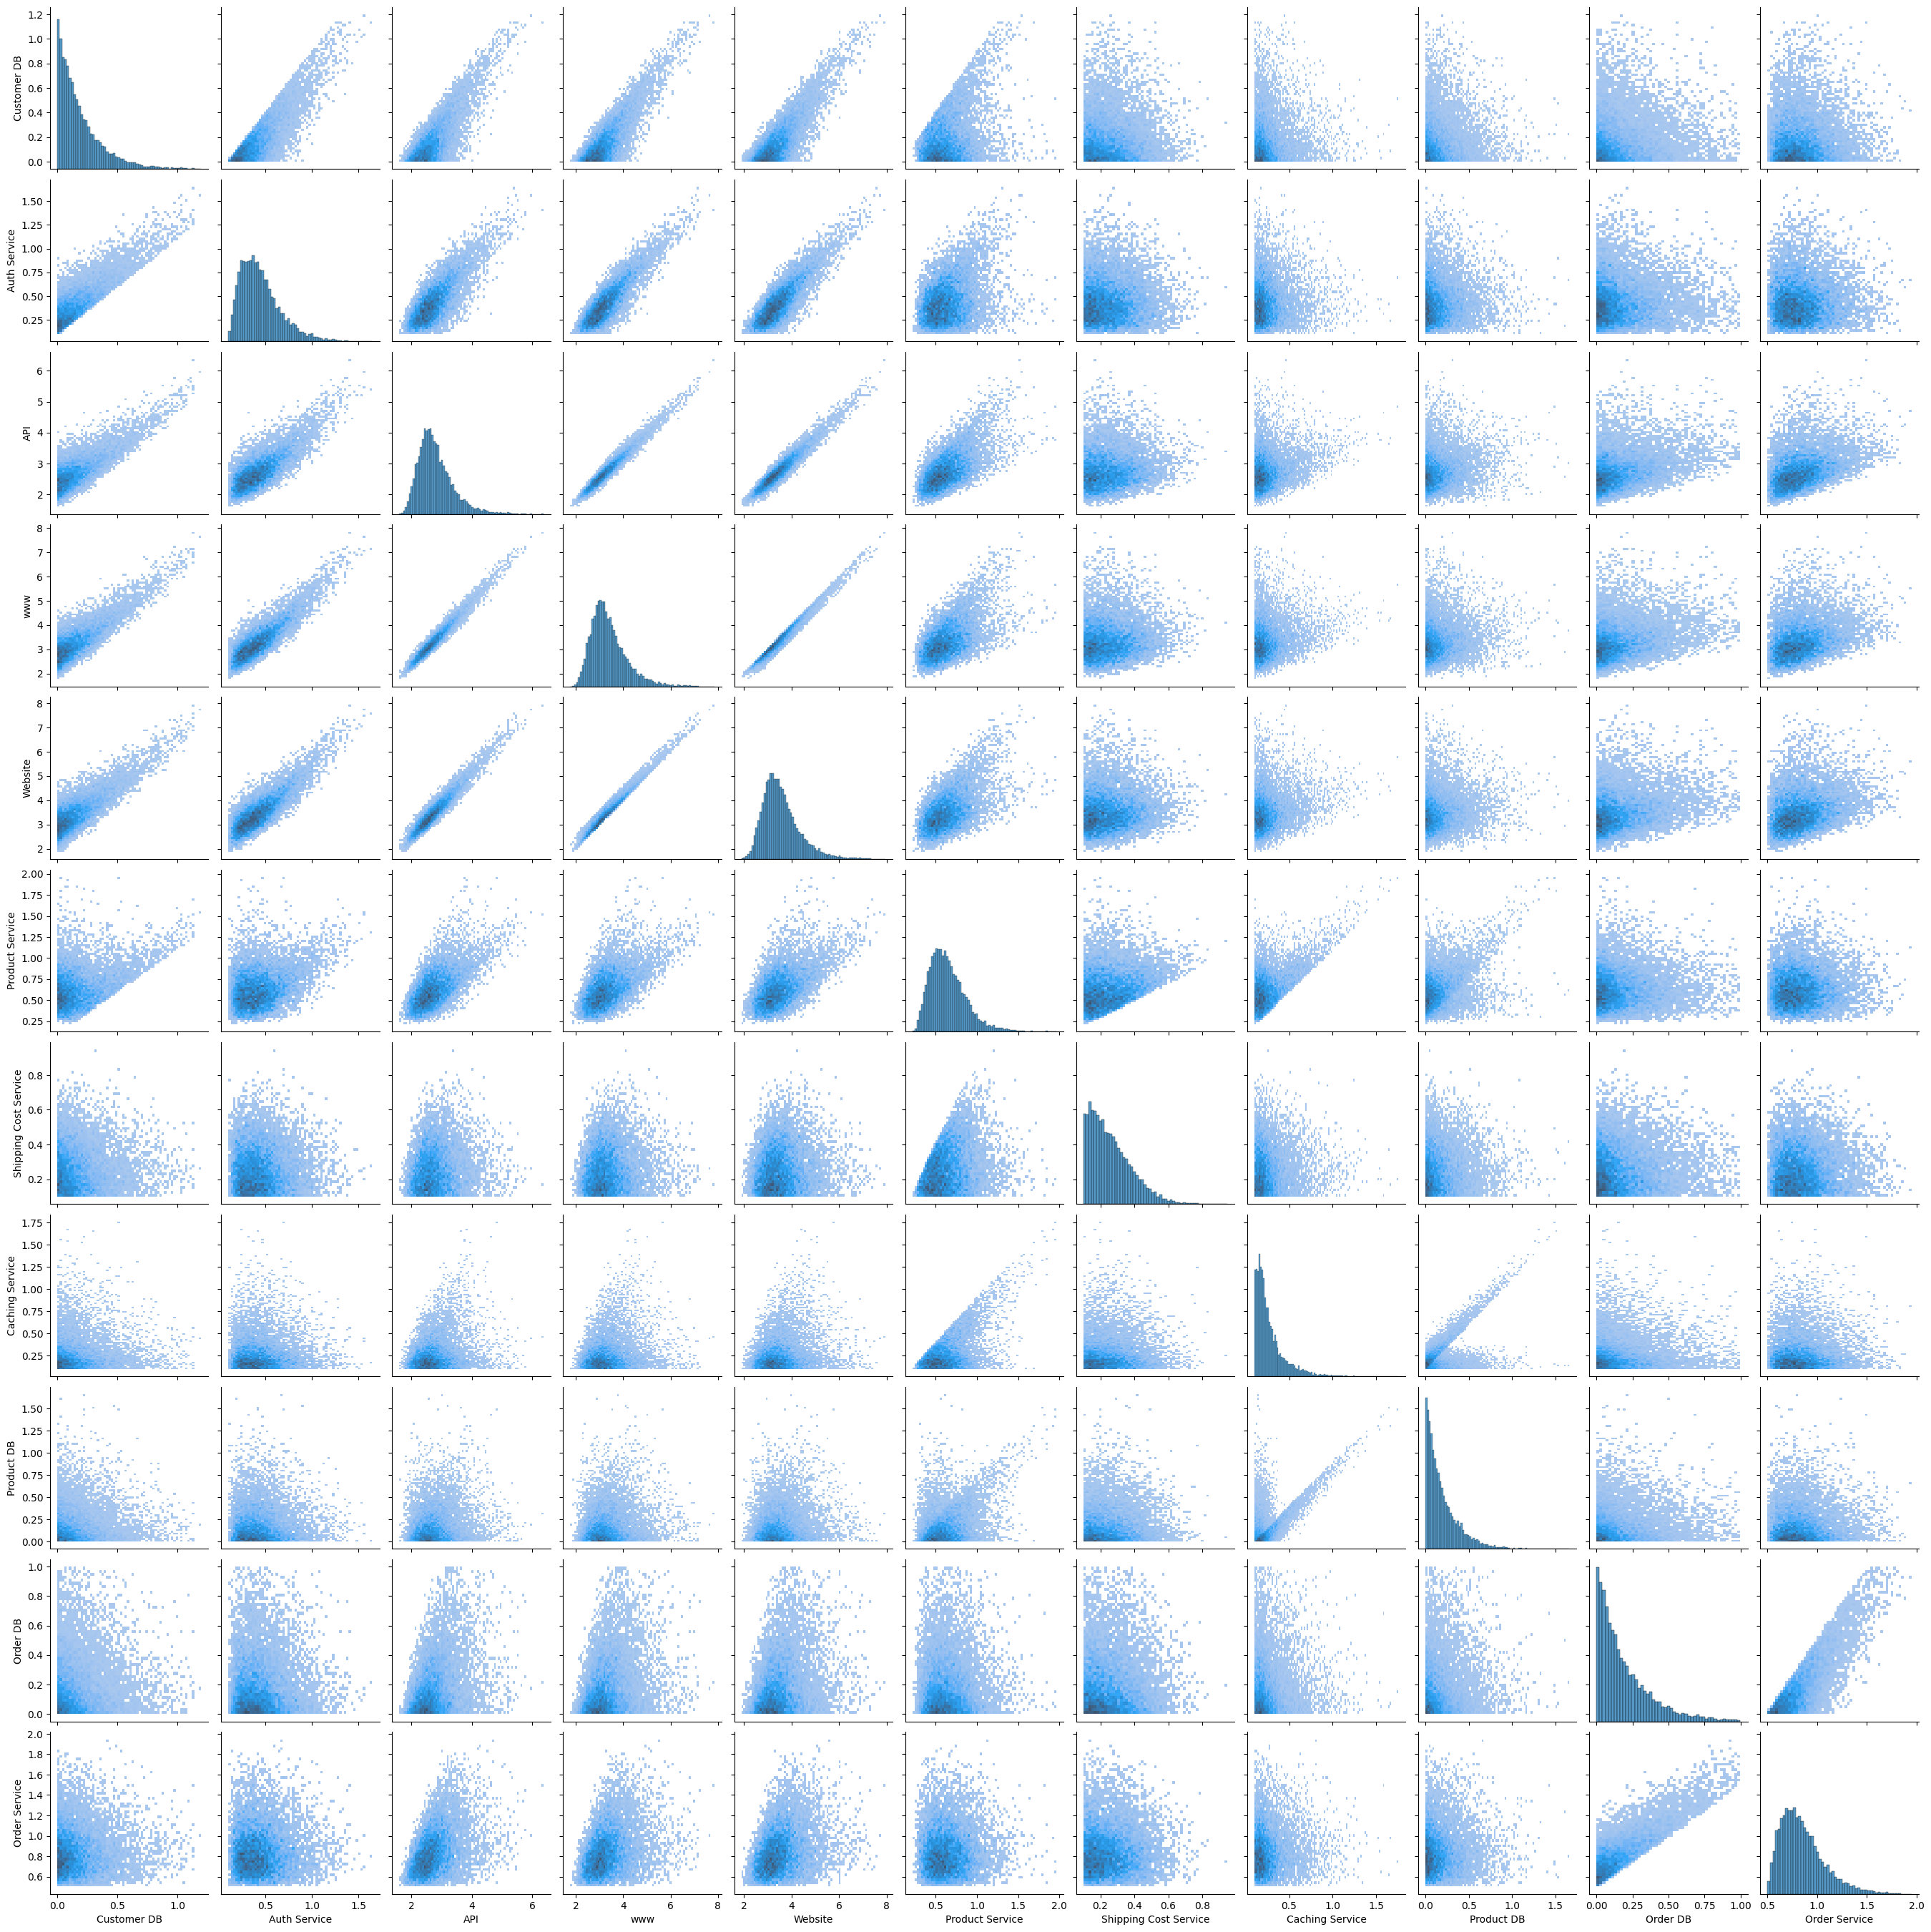

In [6]:
sns.pairplot(microservice_df[reordered_columns],  kind="hist")
plt.show()

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
ECDFs = microservice_df.apply(ECDF, axis=0)
microservice_df_transformed = microservice_df.apply(lambda col: ECDFs[col.name](col))

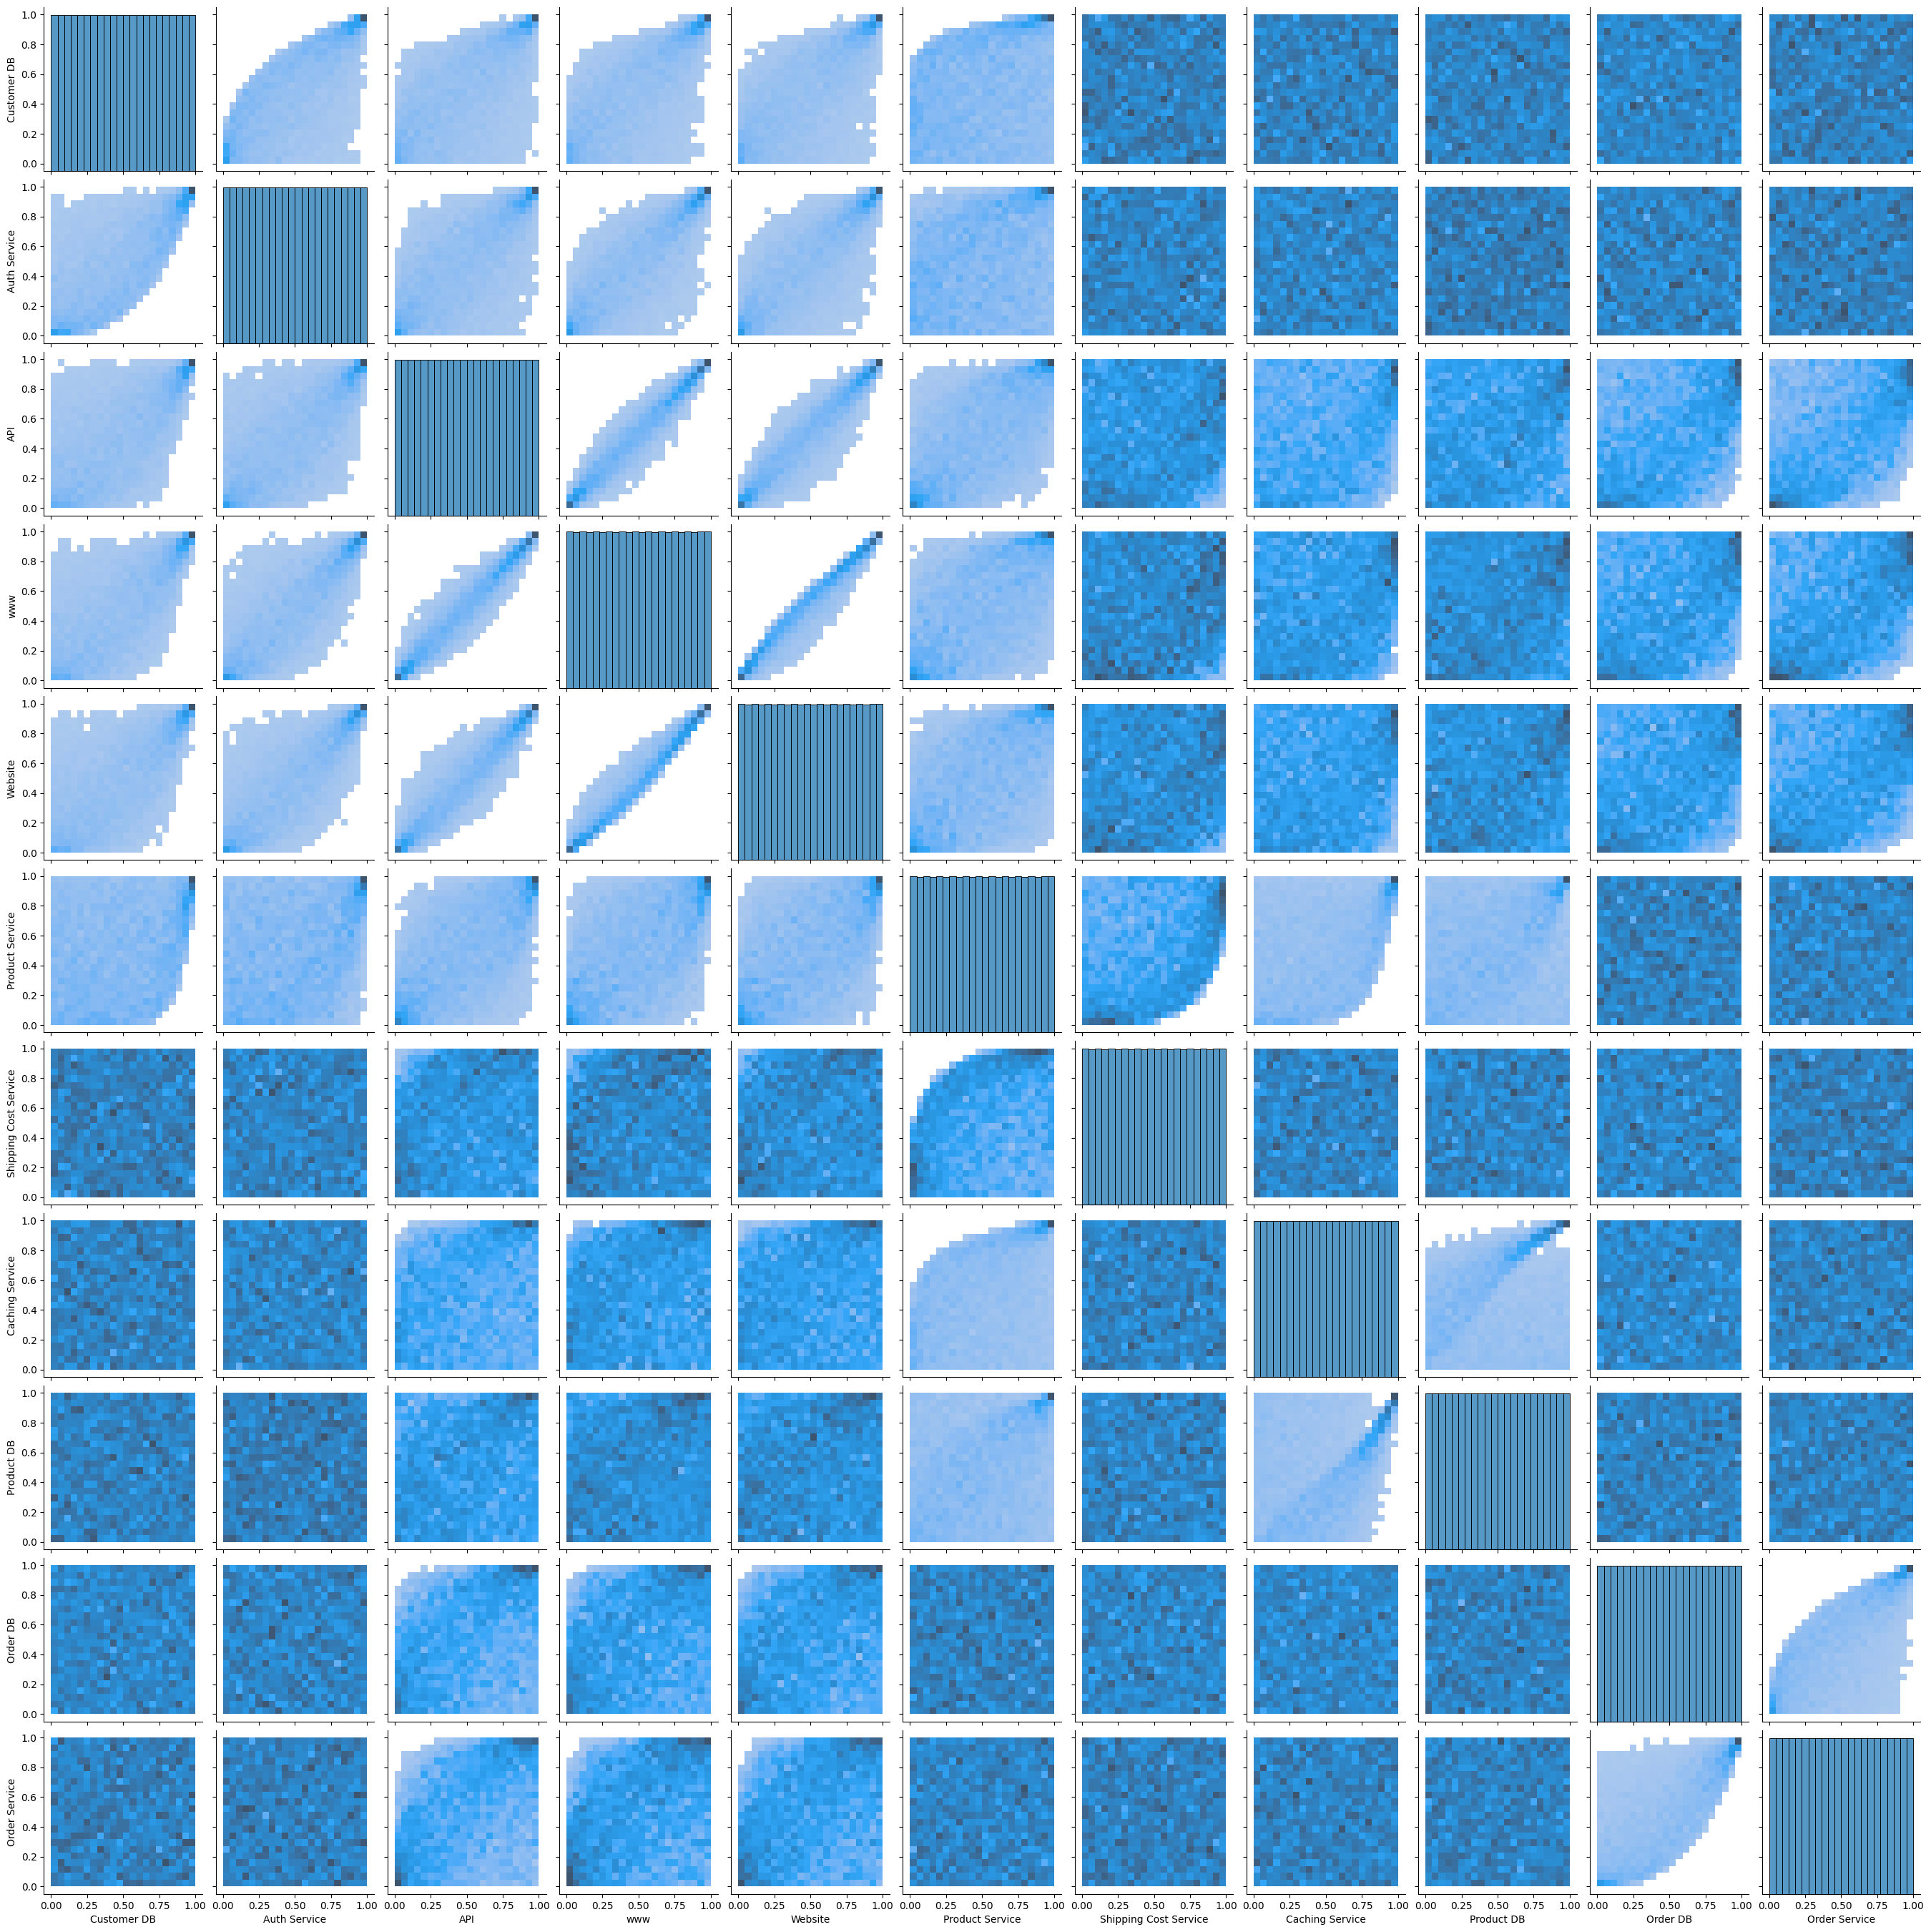

In [8]:
sns.pairplot(microservice_df_transformed[reordered_columns],  kind="hist")
plt.show()

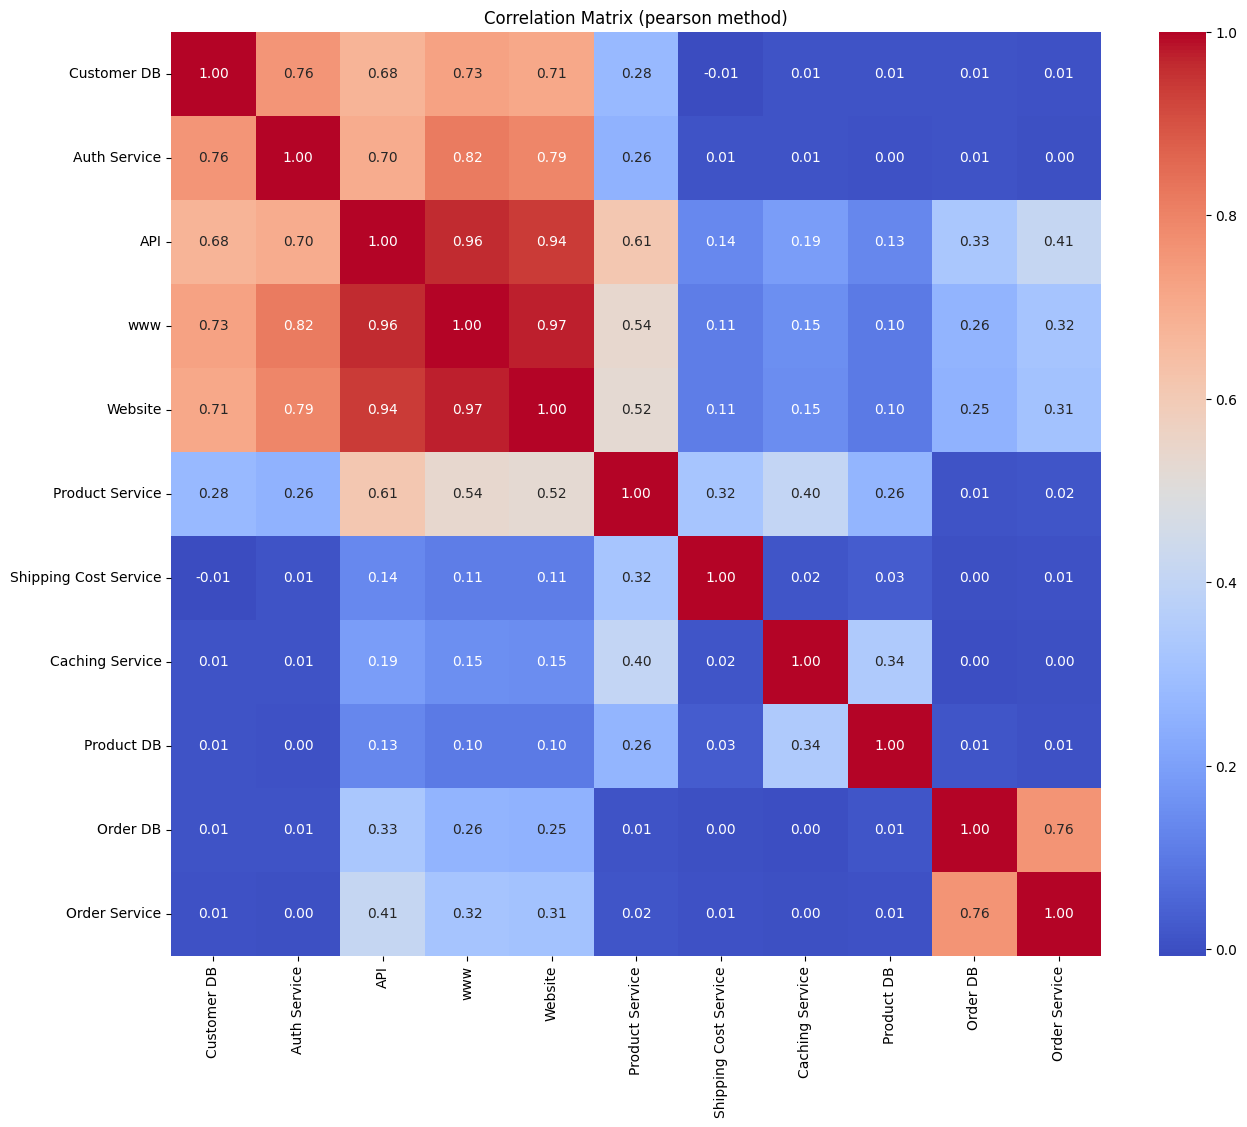

In [9]:
# Loop over correlation methods
plt.figure(figsize=(15, 12))
sns.heatmap(microservice_df_transformed.corr(method='pearson').loc[reordered_columns,reordered_columns], annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title(f'Correlation Matrix (pearson method)')
plt.show()

In [14]:
import numpy as np

# Define a more interesting covariance matrix
cov = microservice_df[reordered_columns].corr(method='pearson')
gaussians = pd.DataFrame(np.random.multivariate_normal(np.zeros(11), cov,size=10000))

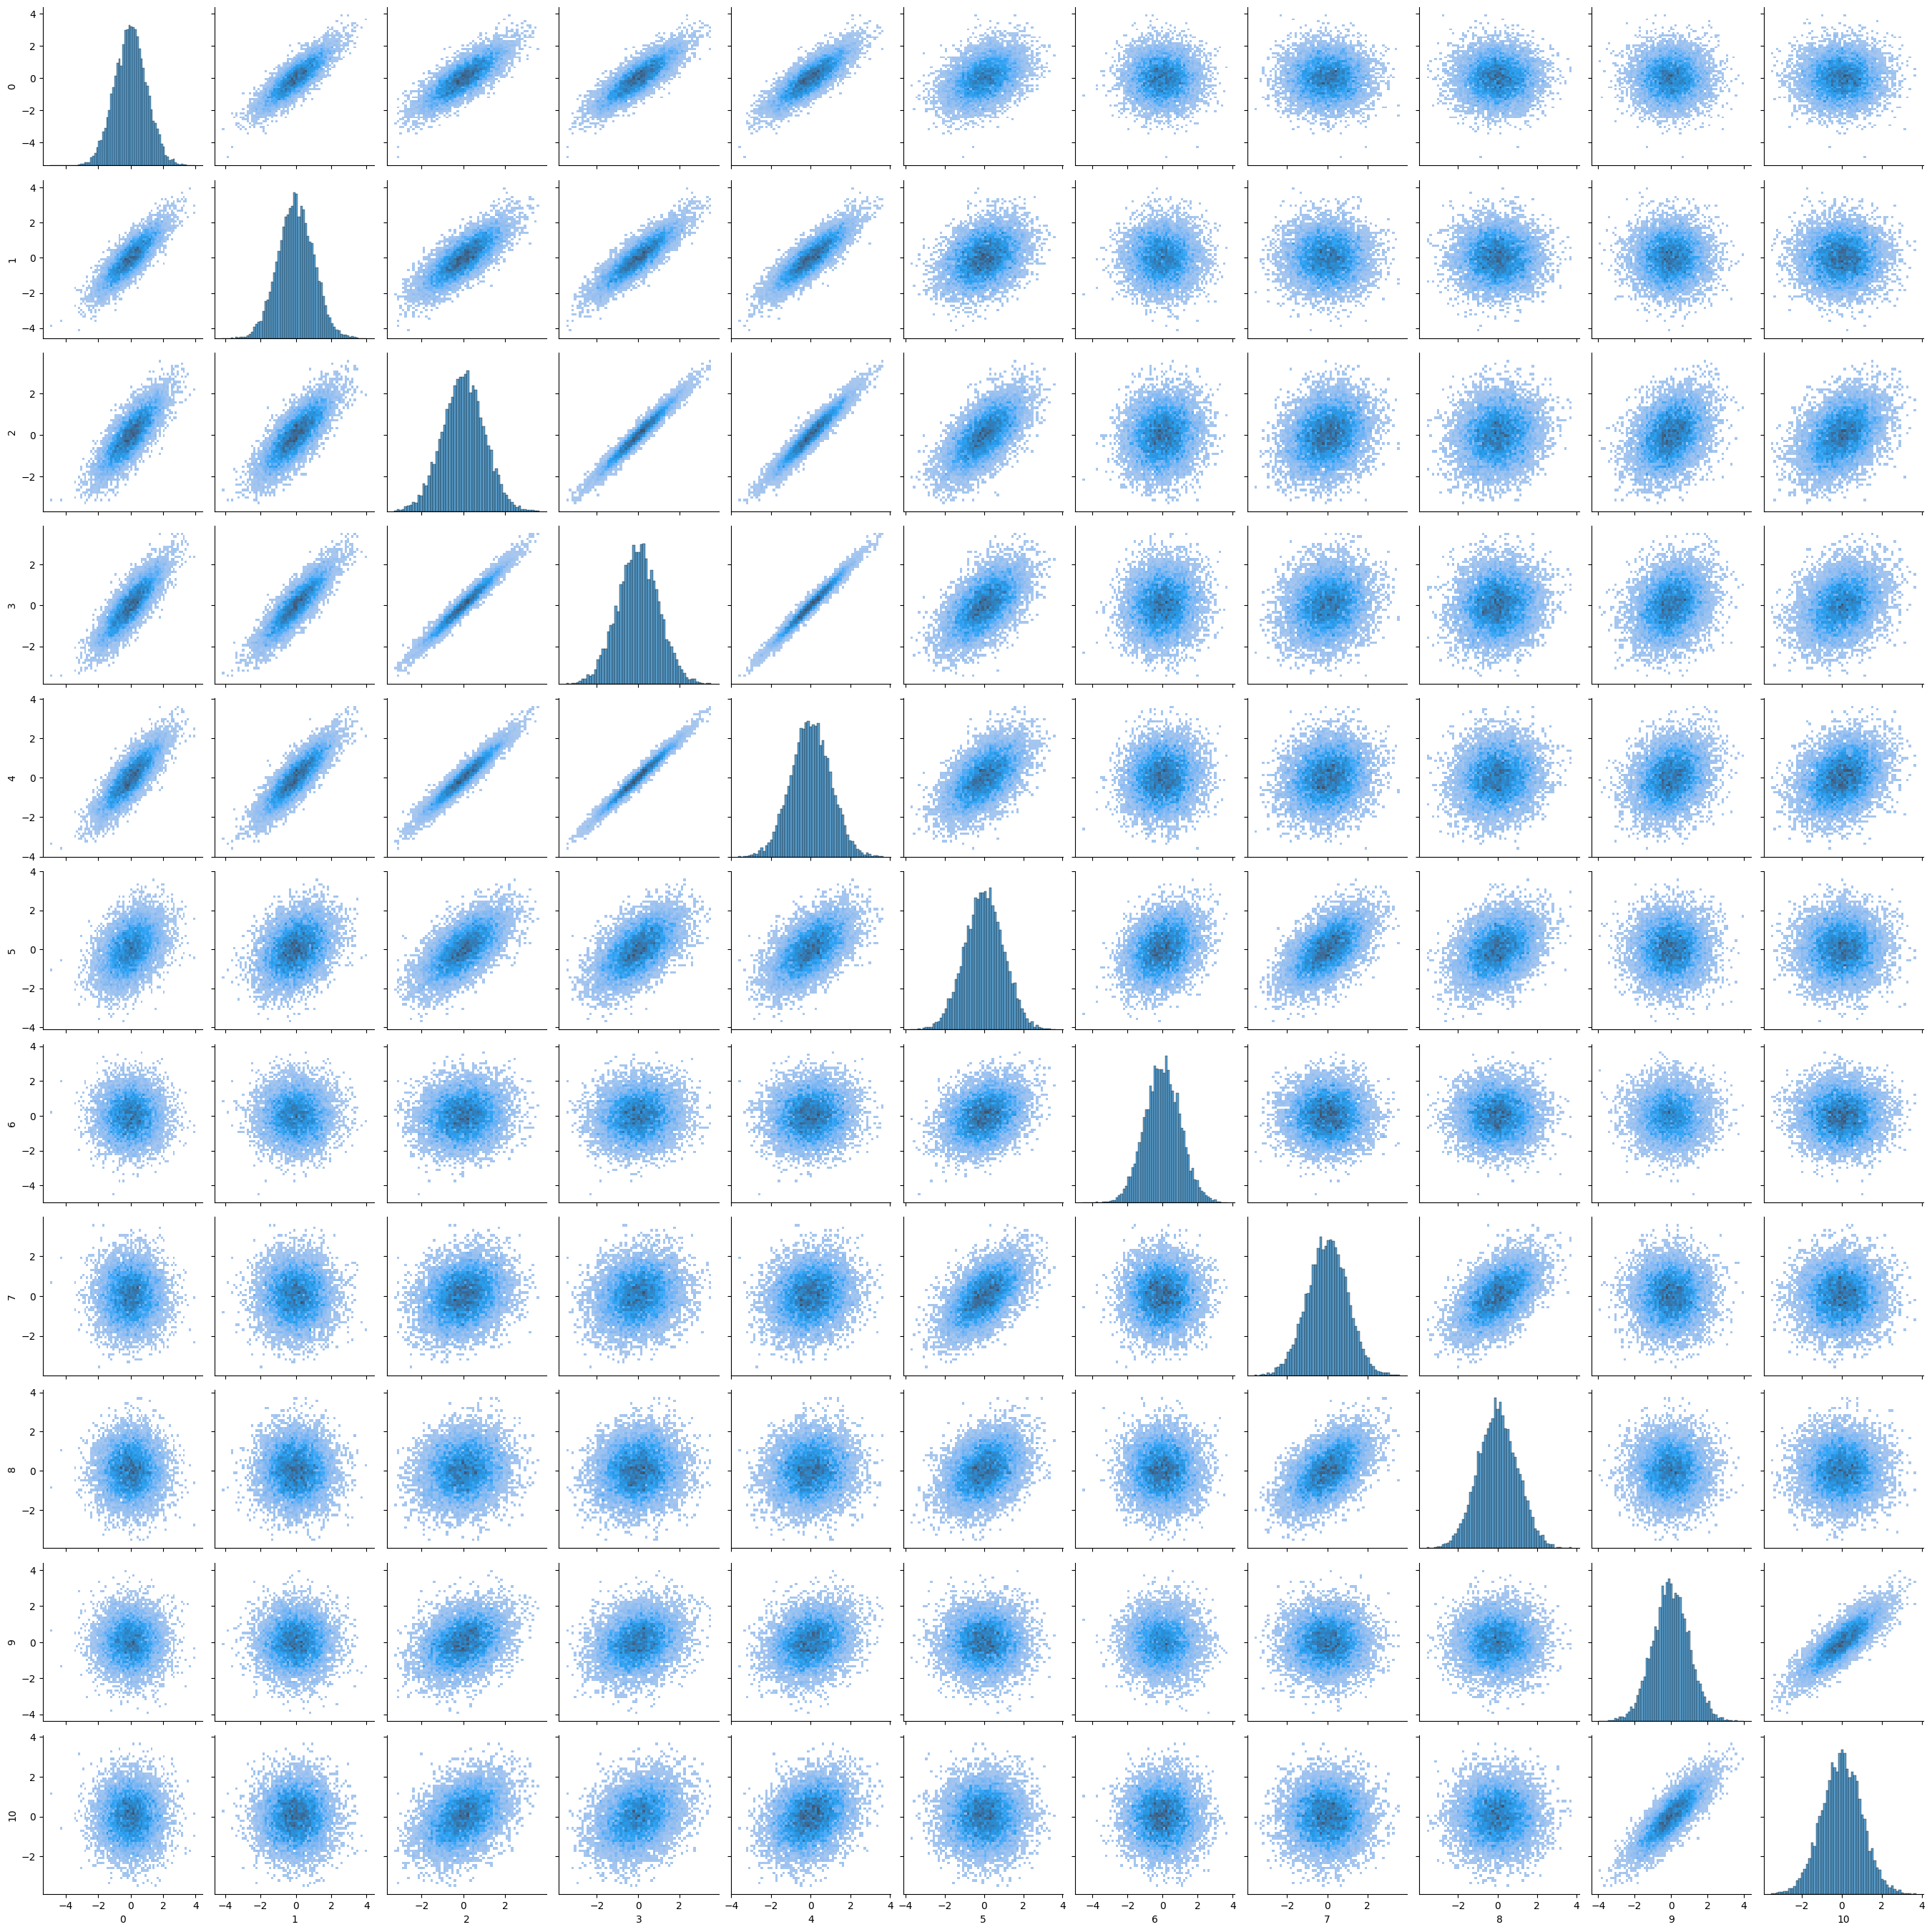

In [15]:
sns.pairplot(gaussians,  kind="hist")
plt.show()

In [16]:
gaussians_transformed = gaussians.apply(lambda col: gaussians.apply(ECDF, axis=0)[col.name](col))

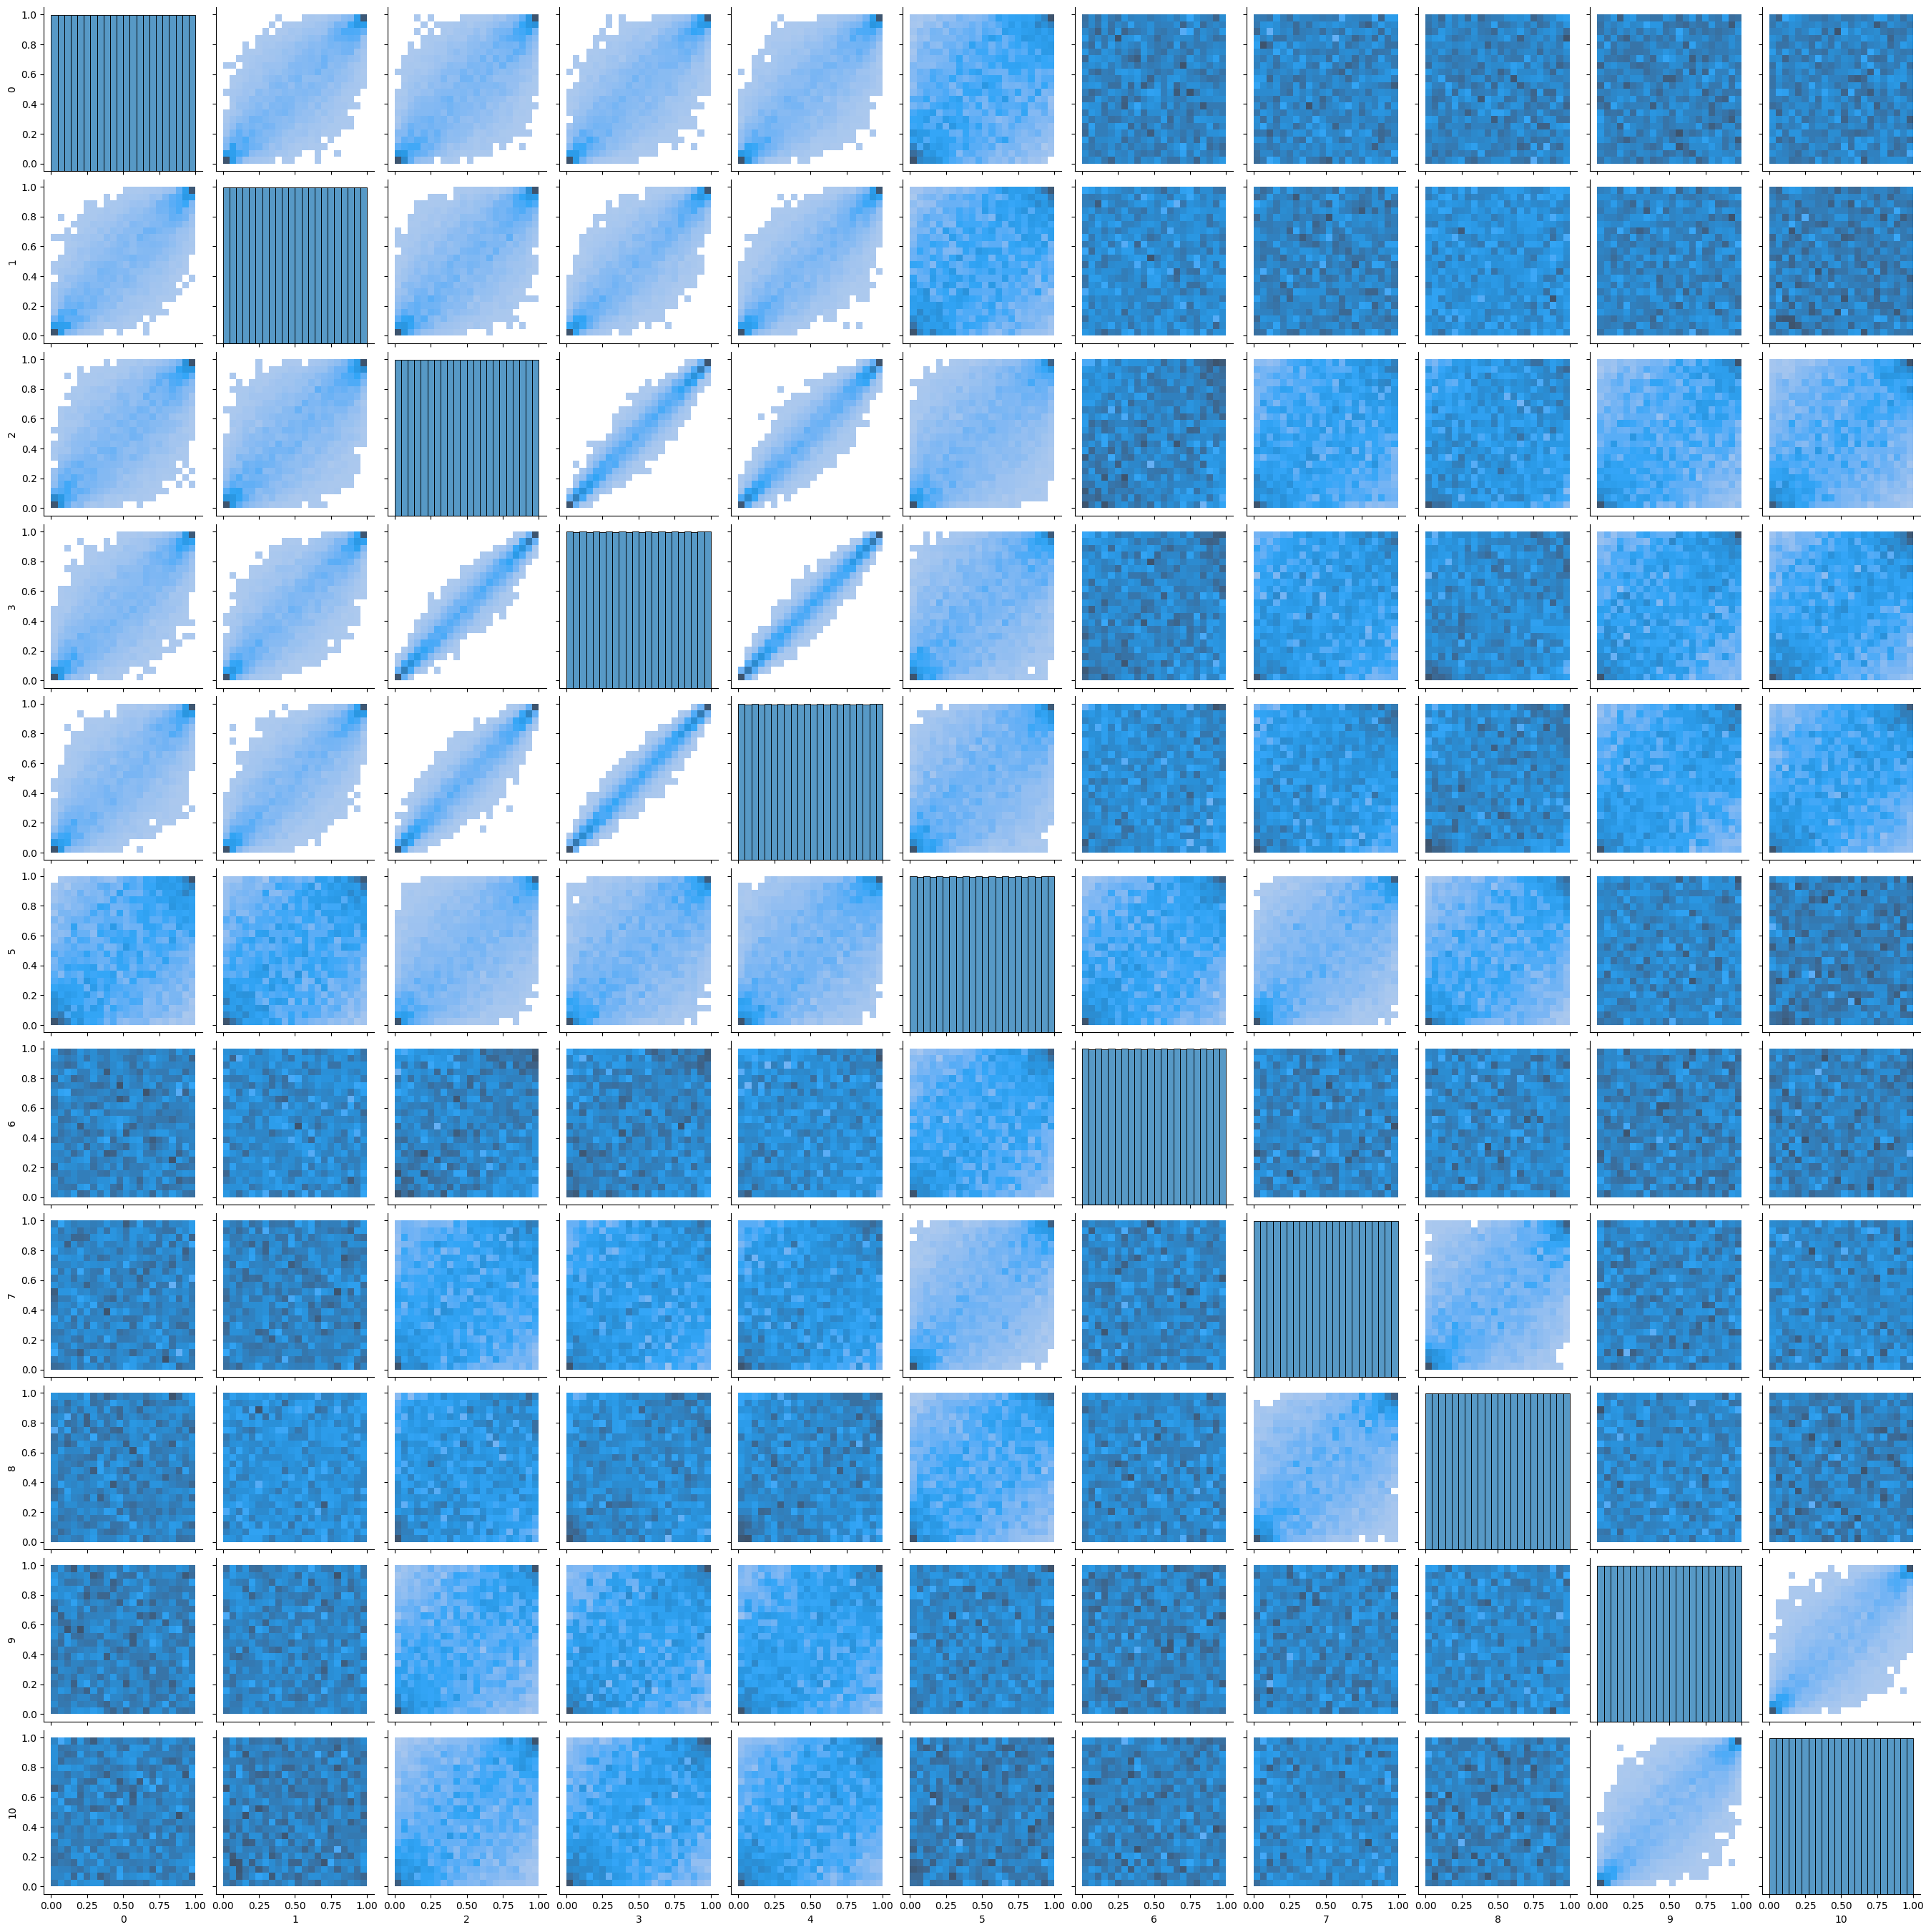

In [17]:
sns.pairplot(gaussians_transformed,  kind="hist")
plt.show()